### Load data

In [1]:
from sklearn import datasets
import pandas as pd
pd.set_option('display.max_columns', None)
import sys
sys.path.append('../../')

diabetes = datasets.load_diabetes()
data = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
target = pd.Series(diabetes.target, name='target')
df = pd.concat([data, target], axis=1)

In [2]:
from tabularmagic import TabularMagic
tm = TabularMagic(df, test_size=0.2, name='Diabetes scikit-learn dataset')
tm

INFO: Initialization complete. Shapes of train, test DataFrames: (353, 11), (89, 
      11). 


Diabetes scikit-learn dataset 
--------------------------------------------------------------------------------
Train shape: (353, 11)                   Test shape: (89, 11)                   
--------------------------------------------------------------------------------
Categorical variables:
  None 
                                                                                
Numerical variables:
  'age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6', 'target' 

### Preprocessing

Force sex to binary (0-and-1-valued continuous) variables

In [3]:
tm.datahandler().force_binary(['sex'])

INFO: Forced variables 'sex' to binary. Variables renamed to 
      '0.05068011873981862_TRUE(sex)'. 


Diabetes scikit-learn dataset 
--------------------------------------------------------------------------------
Train shape: (353, 11)                   Test shape: (89, 11)                   
--------------------------------------------------------------------------------
Categorical variables:
  None 
                                                                                
Numerical variables:
  'age', '0.05068011873981862_TRUE(sex)', 'bmi', 'bp', 's1', 's2', 's3', 's4', 
  's5', 's6', 'target' 

### Conduct exploratory analysis

Visualize the distribution of the target variable statified by sex

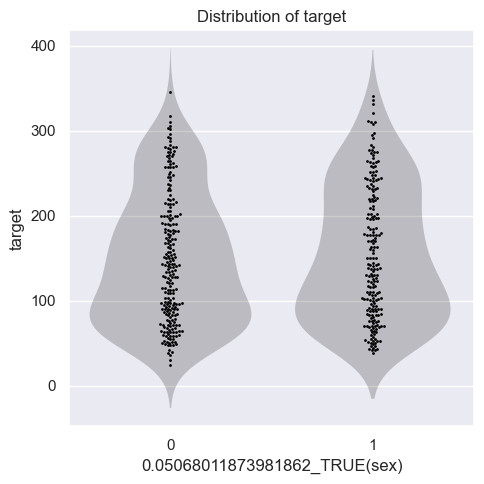

In [4]:
tm.eda(dataset='all').plot_distribution_stratified(
    'target', '0.05068011873981862_TRUE(sex)', strategy='violin_swarm')

Visualize the distribution of the target variable in relation with bmi, age, bp

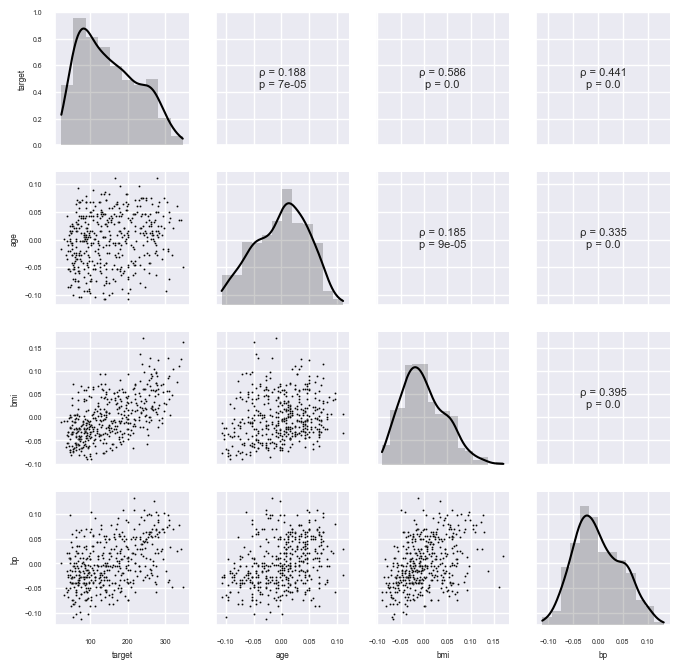

In [5]:
tm.eda(dataset='all').plot_numerical_pairs(
    ['target', 'age', 'bmi', 'bp']
)

### Regression analysis

In [6]:
lm_report = tm.lm(
    formula='target ~ age + bmi + bp + 0.05068011873981862_TRUE(sex) + bp:0.05068011873981862_TRUE(sex)'
)
lm_report.statsmodels_summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     78.41
Date:                Fri, 14 Jun 2024   Prob (F-statistic):           7.28e-55
Time:                        01:28:41   Log-Likelihood:                -1940.0
No. Observations:                 353   AIC:                             3892.
Df Residuals:                     347   BIC:                             3915.
Df Model:                           5                                         
Covariance Type:                  HC3                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                              155.3958      4.605     33.746      0.000     146.370     164.421
age                                 66.5596     68.288      0.975      0.330     -67.281     200.401
bmi                                817.1307     75.365     10.842      0.000     669.417     964.844
bp                                 281.0417     95.802      2.934      0.003      93.273     468.810
0.05068011873981862_TRUE(sex)      -10.5060      6.312     -1.664      0.096     -22.878       1.866
bp:0.05068011873981862_TRUE(sex)   293.8286    124.317      2.364      0.018      50.171     537.486
==============================================================================
Omnibus:                        9.655   Durbin-Watson:                   1.757
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                5.330
Skew:                           0.072   Prob(JB):                       0.0696
Kurtosis:                       2.415   Cond. No.                         53.3
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

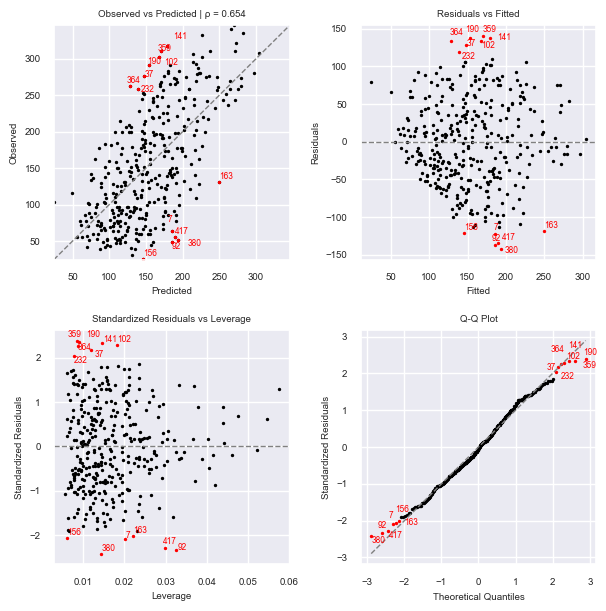

In [7]:
lm_report.train_report().set_outlier_threshold(2).plot_diagnostics(
    show_outliers=True)

In [8]:
lm_report.train_report().fit_statistics()

,OrdinaryLeastSquares
Statistic,
rmse,58.954531
mad,48.701527
pearsonr,0.654225
spearmanr,0.623311
r2,0.42801
adjr2,0.419768
n,353


In [9]:
lm_report.test_report().fit_statistics()

,OrdinaryLeastSquares
Statistic,
rmse,60.750438
mad,49.979177
pearsonr,0.561894
spearmanr,0.552851
r2,0.303415
adjr2,0.261452
n,89


### Machine learning regression benchmarking

Each model performs a grid search to find optimal estimator. Nested k-fold cross validation is performed to assess model fit on train. Models are also assesed on test.

In [10]:
from tabularmagic.ml import CustomR, LinearR, MLPR
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
import numpy as np


ml_report = tm.ml_regression(
    models=[
        CustomR(
            estimator=Lasso(alpha=0.1),
            name='Lasso alpha=0.1'
        ),
        CustomR(
            estimator=GridSearchCV(
                estimator=Lasso(alpha=0.5),
                param_grid={'alpha': np.logspace(-4, 4, 10)},
            ),
            name='Lasso with gridsearch'
        ),
        CustomR(
            estimator=Pipeline(
                steps=[
                    ('feature_selection', SelectKBest(k=2)),
                    ('regression', GridSearchCV(
                        estimator=Lasso(alpha=0.5),
                        param_grid={'alpha': np.logspace(-4, 4, 10)}
                    ))
                ]
            ),
            name='pipeline example'
        ),
        LinearR('l1'),
        MLPR()
    ],
    y_var='target',
    X_vars=['age', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6'],
    outer_cv=5,
    outer_cv_seed=0
)

INFO: Fitting model Lasso alpha=0.1. 
INFO: Fitted model Lasso alpha=0.1. 
INFO: Fitting model Lasso with gridsearch. 
INFO: Fitted model Lasso with gridsearch. 
INFO: Fitting model pipeline example. 
INFO: Fitted model pipeline example. 
INFO: Fitting model LinearR(l1). 
INFO: Fitted model LinearR(l1). 
INFO: Fitting model MLPR. 
INFO: Fitted model MLPR. 


View test fit statistics

In [11]:
ml_report.fit_statistics('test')

,Lasso alpha=0.1,Lasso with gridsearch,pipeline example,LinearR(l1),MLPR
Statistic,,,,,
rmse,53.766228,54.034104,53.856748,53.863011,56.215125
mad,43.798108,43.870287,44.080882,43.826755,46.781418
pearsonr,0.67637,0.674763,0.673109,0.675814,0.638443
spearmanr,0.664343,0.664394,0.660129,0.664266,0.61857
r2,0.454374,0.448924,0.452536,0.452408,0.403539
adjr2,0.392215,0.386143,0.390166,0.390024,0.335588
n,89,89,89,89,89


View train fit statistics

In [12]:
ml_report.fit_statistics('train')

,Lasso alpha=0.1,Lasso with gridsearch,pipeline example,LinearR(l1),MLPR
Statistic,,,,,
rmse,54.942068,54.771258,57.381337,54.856794,58.748719
mad,45.175939,44.94668,47.634954,45.073173,49.072904
pearsonr,0.710459,0.711805,0.67701,0.711136,0.6712
spearmanr,0.694555,0.697025,0.667051,0.696171,0.663129
r2,0.50322,0.506304,0.45813,0.504761,0.431997
adjr2,0.490185,0.49335,0.443912,0.491767,0.417093
n,353,353,353,353,353


View averaged fit statistics across folds

In [13]:
ml_report.cv_fit_statistics()

,Lasso alpha=0.1,Lasso with gridsearch,pipeline example,LinearR(l1),MLPR
Statistic,,,,,
rmse,55.806346,55.710156,59.225259,56.300856,59.298803
mad,46.060357,45.842629,49.355747,46.144134,49.750436
pearsonr,0.704991,0.70642,0.650358,0.699251,0.663402
spearmanr,0.681986,0.681679,0.645978,0.677564,0.644952
r2,0.477922,0.479664,0.408032,0.468273,0.410322
adjr2,0.40033,0.40233,0.320008,0.389243,0.322691
n,70.6,70.6,70.6,70.6,70.6


Obtain the scikit-learn estimator

In [14]:
ml_report.model('MLPR').sklearn_estimator()

MLPRegressor(hidden_layer_sizes=(100, 50, 25), random_state=42)

View MLPR fit on train data

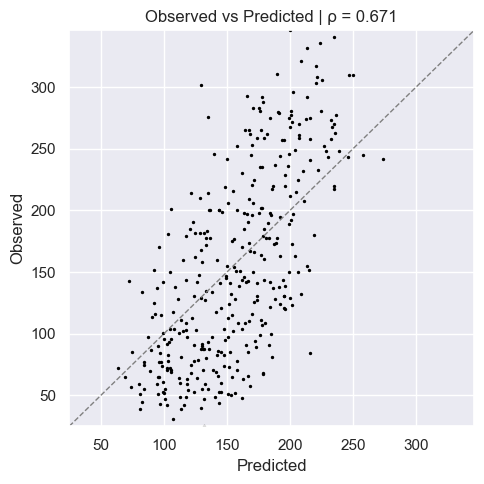

In [15]:
ml_report.model_report('MLPR').train_report().plot_obs_vs_pred()

View MLPR fit on test data

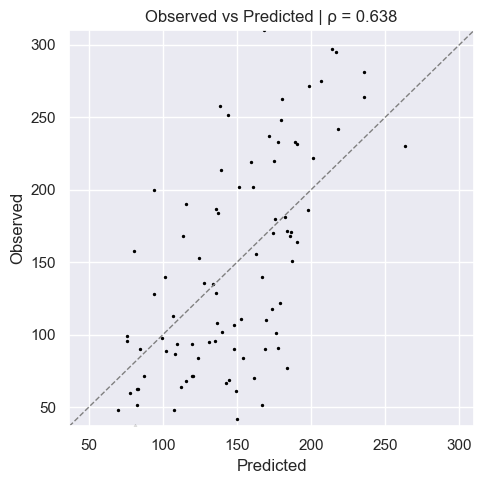

In [16]:
ml_report.model_report('MLPR').test_report().plot_obs_vs_pred()